In [4]:
import pandas as pd

# Load the dataset
file_path = r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\data_tshikama_xls-1 (1).xlsx' 
# Replace with your file path
df = pd.read_excel(file_path)

# Ensure columns are named correctly
df.columns = ['ciluba', 'french', 'score', 'sentiment', 'nature']
df

,ciluba,french,score,sentiment,nature
0,Akaja,Arrange,1,Positif,Verbe
1,Akajilula,Rearrange,1,Positif,Verbe
2,Akula,Parle,2,Positif,Verbe
3,Akulula,Reparle,2,Positif,Verbe
4,Aluja,Remet,3,Positif,Verbe
...,...,...,...,...,...
2995,Tudi ne,elle a,0,Neutre,Verbe
2996,Nudi ne,nous avons,0,Neutre,Verbe
2997,badi ne,vous avez,0,Neutre,Verbe
2998,Tshiabu,pour eux,0,Neutre,Adjectif


In [ ]:
import pandas as pd
from deep_translator import MyMemoryTranslator
from tqdm import tqdm
import numpy as np

# Translation function using MyMemoryTranslator
def translate_text(text, source_language, target_language):
    try:
        translator = MyMemoryTranslator(source=source_language, target=target_language)
        translation = translator.translate(text)
        return translation
    except Exception as e:
        return f"Error: {e}"

# Function to translate a row
def translate_row(row):
    try:
        # Translate from French to English
        english = translate_text(row['french'], source_language='fr-FR', target_language='en-GB')
        # Translate from English to Afrikaans
        afrikaans = translate_text(english, source_language='en-GB', target_language='af-ZA')
        # Translate from English to Zulu
        zulu = translate_text(english, source_language='en-GB', target_language='zu-ZA')
        # Translate from English to Xhosa
        xhosa = translate_text(english, source_language='en-GB', target_language='xh-ZA')
        return pd.Series({'English': english, 'Afrikaans': afrikaans, 'Zulu': zulu, 'Xhosa': xhosa})
    except Exception as e:
        return pd.Series({'English': None, 'Afrikaans': None, 'Zulu': None, 'Xhosa': None})

if __name__ == '__main__':
    # Load the dataset
    file_path = r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\data_tshikama_xls-1 (1).xlsx'
    df = pd.read_excel(file_path)

    # Ensure columns are named correctly
    df.columns = ['ciluba', 'french', 'score', 'sentiment', 'nature']

    # Define batch size
    batch_size = 500
    start_index = 1000  # Starting from the 501st row
    end_index = 1500   # Ending at the 1000th row

    # Slice the DataFrame to process only the desired batch
    df_batch = df.iloc[start_index:end_index]

    # Apply the translation row by row with a progress bar
    tqdm.pandas()
    translations = df_batch.progress_apply(translate_row, axis=1)
    df_translated_batch = pd.concat([df_batch, translations], axis=1)

    # Save the translated batch to Excel
    output_file = r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\lexicon_expanded_batch_1001_to_1500.xlsx'
    df_translated_batch.to_excel(output_file, index=False)

    print(f"Success! Translated batch saved to {output_file}")


In [ ]:
#Sentiment analysis 1 - textblob
from textblob import TextBlob
import pandas as pd

# Load the lexicon file
lexicon_df = pd.read_excel(r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\lexicon_expanded.xlsx')

# Define a function to calculate sentiment
def get_sentiment(text):
    text = str(text)  # Ensure the text is a string
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    sentiment_label = 'Positive' if polarity > 0 else 'Negative' if polarity < 0 else 'Neutral'
    return polarity, sentiment_label

# Apply sentiment analysis for each language
for lang in ['English', 'Afrikaans', 'Zulu', 'Xhosa']:
    lexicon_df[f'{lang}_sentiment_score'], lexicon_df[f'{lang}_sentiment'] = zip(
        *lexicon_df[lang].apply(lambda x: get_sentiment(x) if pd.notnull(x) else (0, 'Neutral'))
    )

# Save the expanded lexicon with sentiment analysis
lexicon_df.to_excel(r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\lexicon_expanded_with_sentiment_textblob.xlsx', index=False)

# Display the first few rows to verify
print(lexicon_df.head())


  Unnamed: 0     french  score sentiment nature       English    Afrikaans  \
0      Akaja    Arrange      1   Positif  Verbe      Organize   Organiseer   
1  Akajilula  Rearrange      1   Positif  Verbe     Rearrange  Herrangskik   
2      Akula      Parle      2   Positif  Verbe        Spoken     Gespreek   
3    Akulula    Reparle      2   Positif  Verbe  Speaks again   Praat Weer   
4      Aluja      Remet      3   Positif  Verbe        Resets      Herstel   

               Zulu                 Xhosa  English_sentiment_score  \
0             Hlela           Lungiselela                      0.0   
1     Hlela kabusha  Lungiselela kwakhona                      0.0   
2       Kukhulunywe            Iyathethwa                      0.0   
3  Iphinde ikhulume    Uyathetha kwakhona                      0.0   
4  Ukusetha kabusha     Ukusetha kwakhona                      0.0   

  English_sentiment  Afrikaans_sentiment_score Afrikaans_sentiment  \
0           Neutral                     

In [ ]:
#Sentiment 2 - vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the lexicon file
lexicon_df = pd.read_excel(r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\lexicon_expanded.xlsx')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment using VADER
def get_vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(str(text))  # Ensure text is a string
    polarity = sentiment_scores['compound']  # Compound score is a normalized composite score
    sentiment_label = 'Positive' if polarity > 0 else 'Negative' if polarity < 0 else 'Neutral'
    return polarity, sentiment_label

# Apply sentiment analysis for each language
for lang in ['English', 'Afrikaans', 'Zulu', 'Xhosa']:
    lexicon_df[f'{lang}_sentiment_score'], lexicon_df[f'{lang}_sentiment'] = zip(
        *lexicon_df[lang].apply(get_vader_sentiment)
    )

# Save the expanded lexicon with sentiment analysis
lexicon_df.to_excel(r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\vaderAnalysis.xlsx', index=False)

# Display the first few rows to verify
print(lexicon_df.head())


  Unnamed: 0     french  score sentiment nature       English    Afrikaans  \
0      Akaja    Arrange      1   Positif  Verbe      Organize   Organiseer   
1  Akajilula  Rearrange      1   Positif  Verbe     Rearrange  Herrangskik   
2      Akula      Parle      2   Positif  Verbe        Spoken     Gespreek   
3    Akulula    Reparle      2   Positif  Verbe  Speaks again   Praat Weer   
4      Aluja      Remet      3   Positif  Verbe        Resets      Herstel   

               Zulu                 Xhosa  English_sentiment_score  \
0             Hlela           Lungiselela                      0.0   
1     Hlela kabusha  Lungiselela kwakhona                      0.0   
2       Kukhulunywe            Iyathethwa                      0.0   
3  Iphinde ikhulume    Uyathetha kwakhona                      0.0   
4  Ukusetha kabusha     Ukusetha kwakhona                      0.0   

  English_sentiment  Afrikaans_sentiment_score Afrikaans_sentiment  \
0           Neutral                     

C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis'

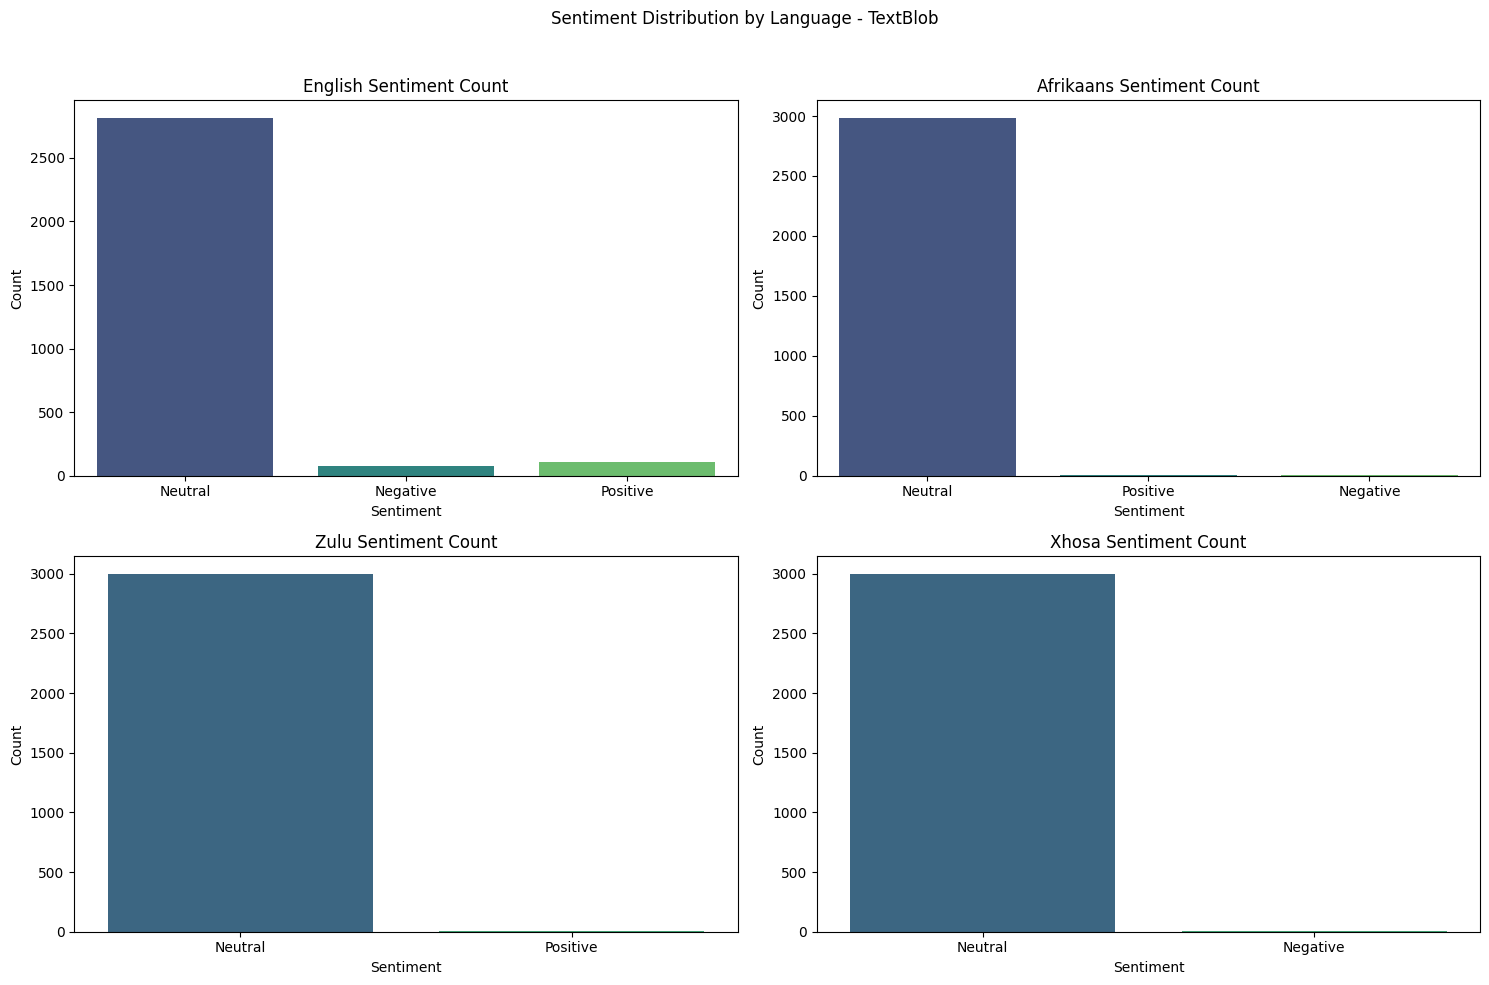

C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palet

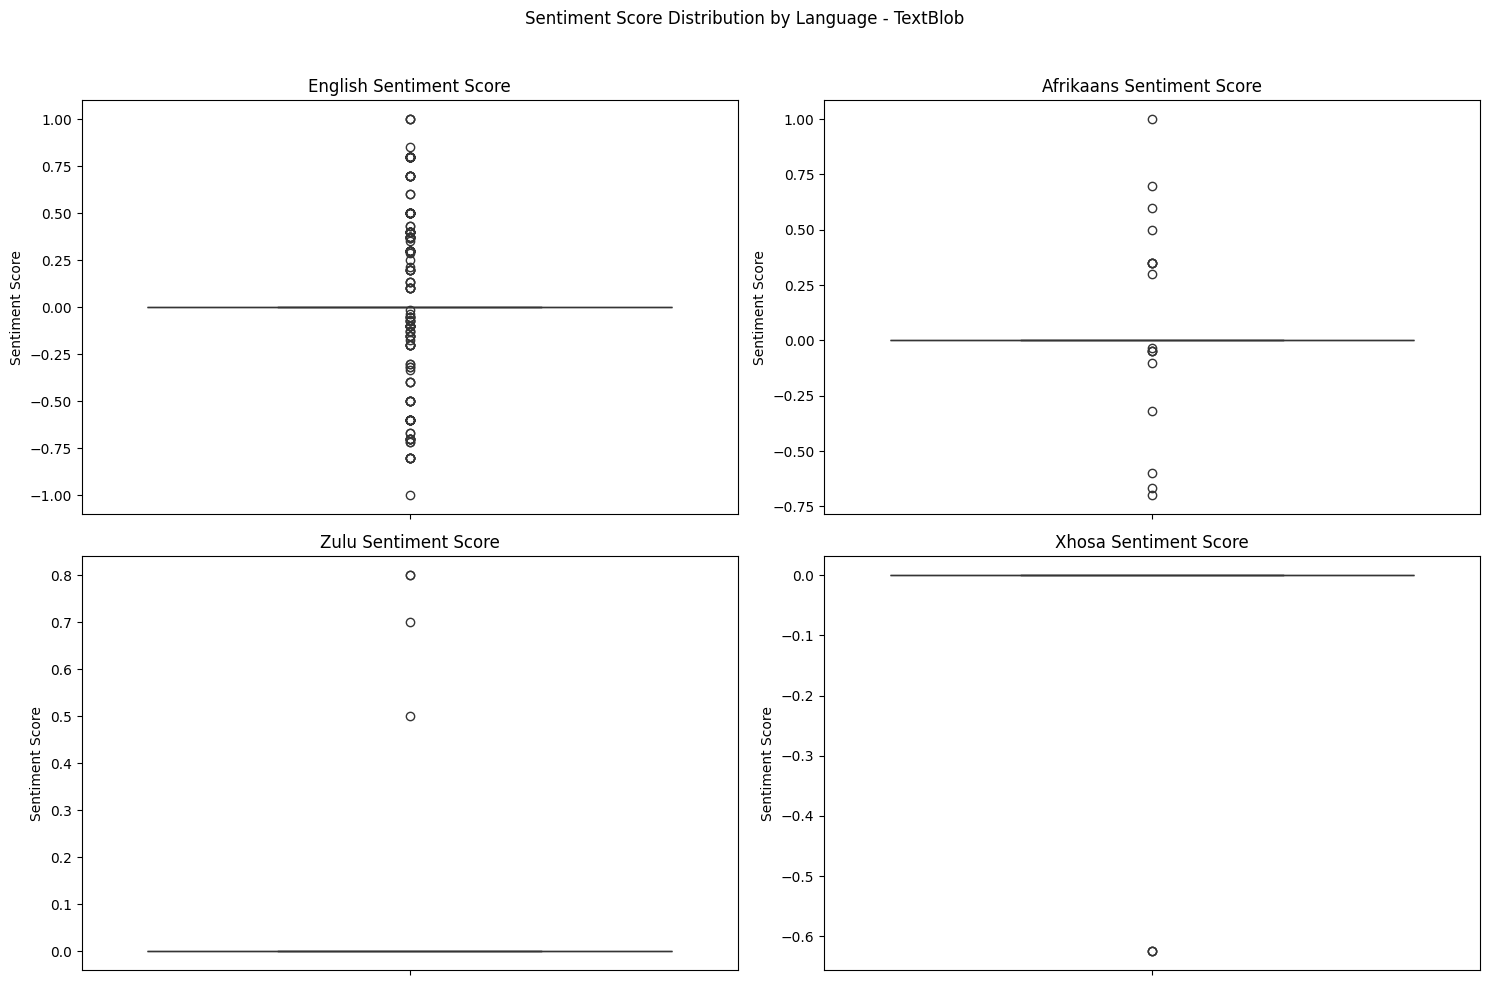

C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis'

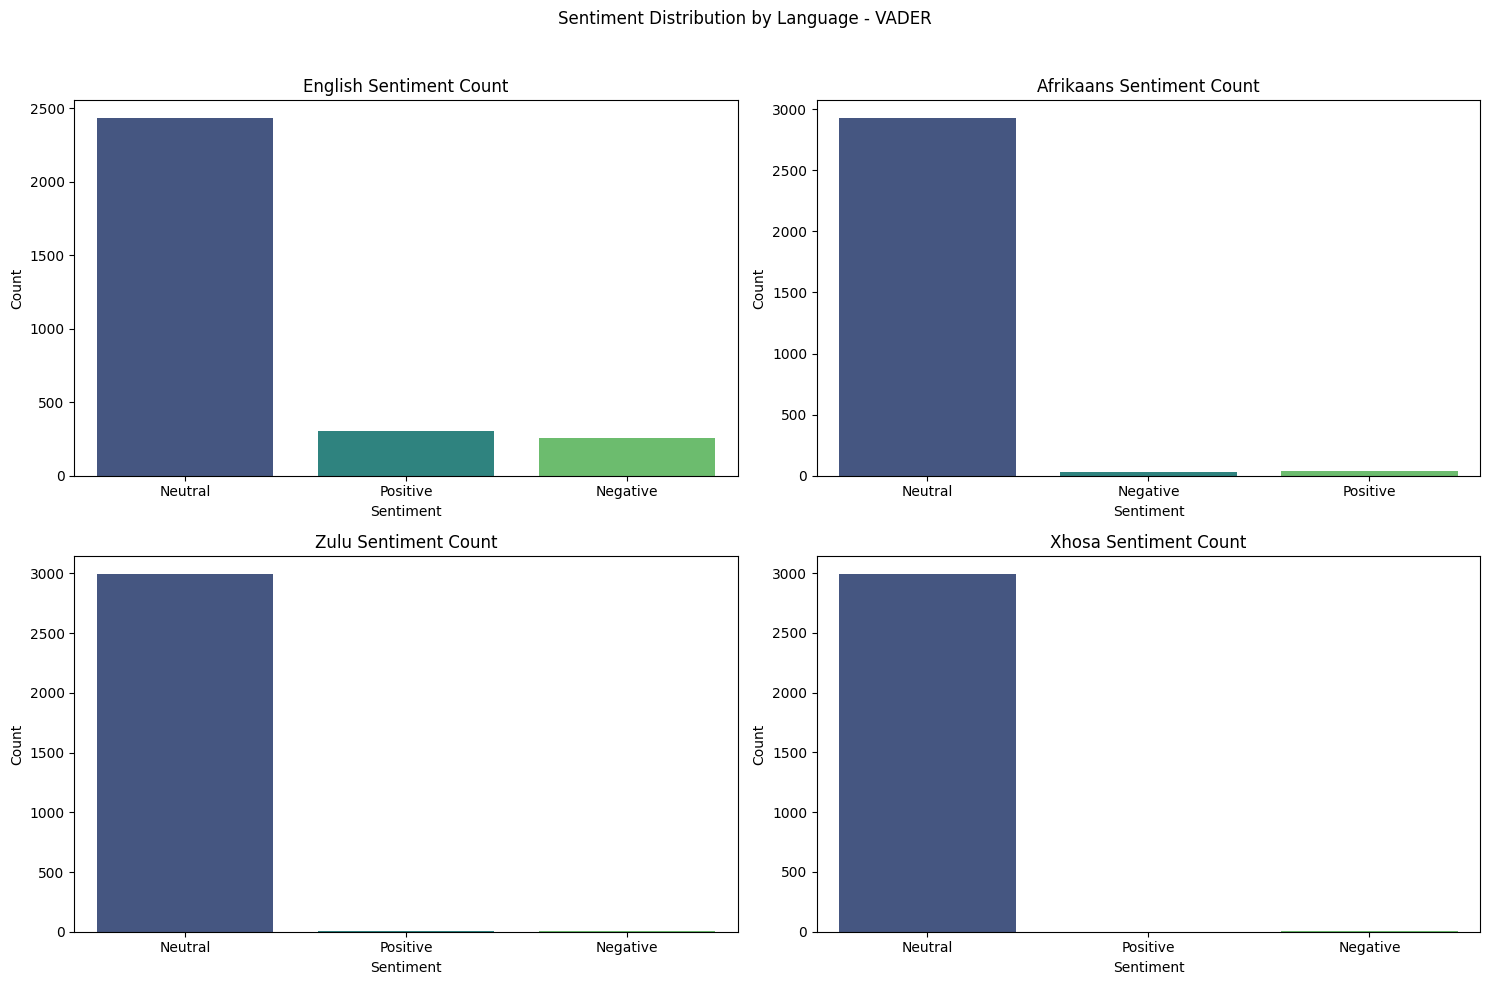

C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palette='viridis')
C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_67572\3734630652.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palet

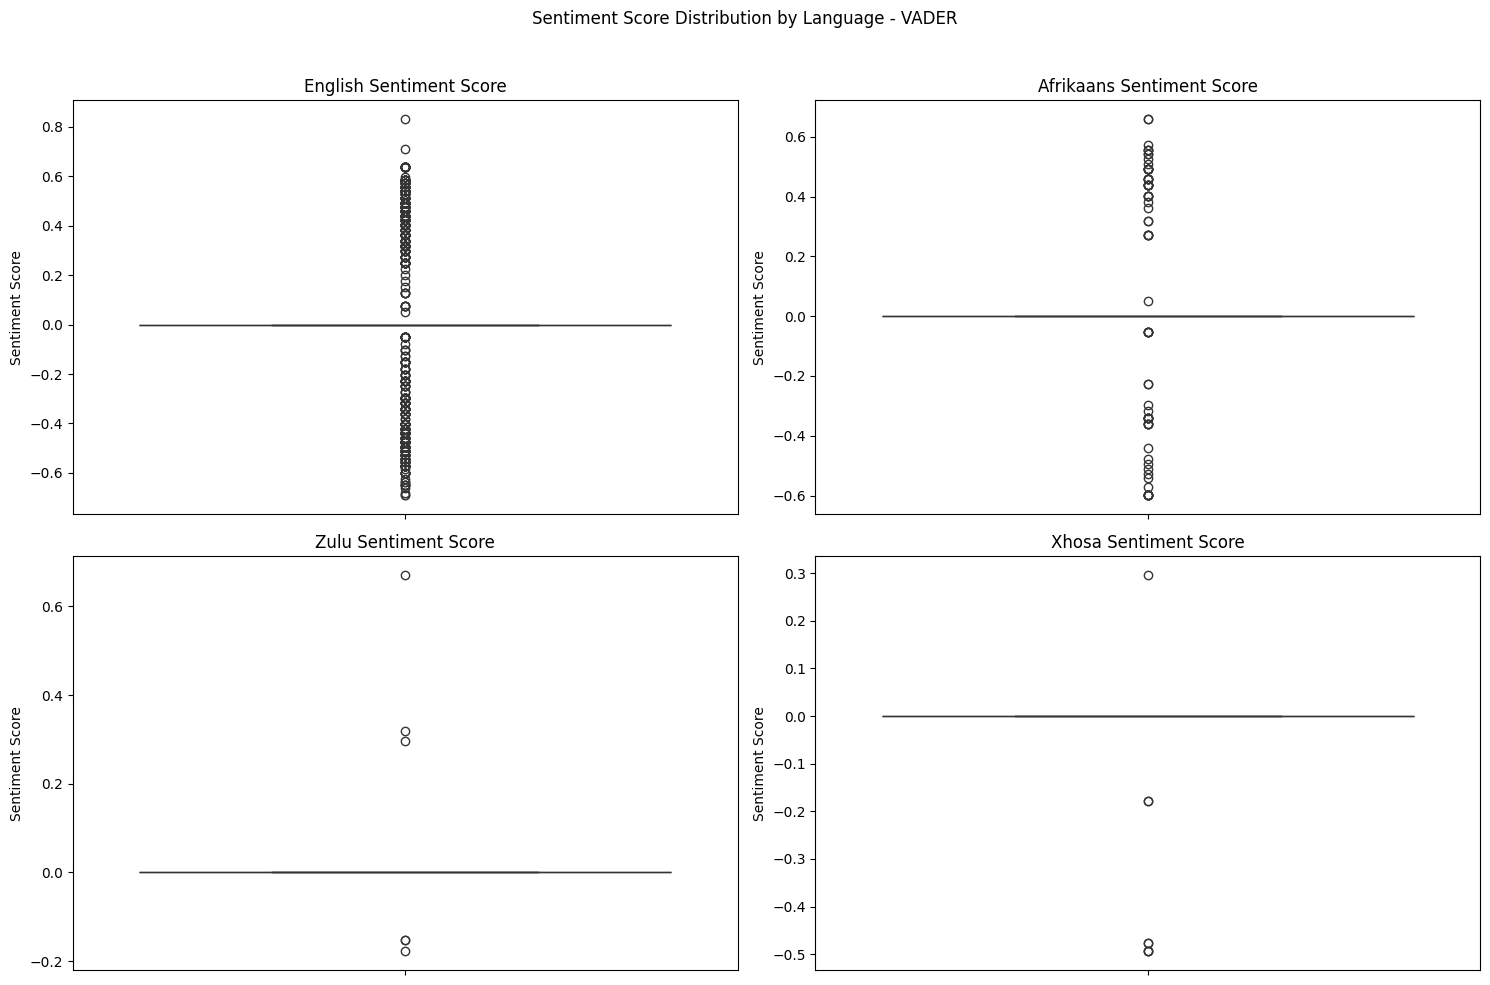

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Python312\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Python312\Lib\asyncio\selector_events.py", line 132, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Python312\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Python312\Lib\asyncio\selector_events.py", line 132, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection w

In [ ]:
#Graphs for the sentiment analysis
#Graphs for sentiment for each language:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data files
textblob_df = pd.read_excel(r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\lexicon_expanded_with_sentiment_textblob.xlsx')
vader_df = pd.read_excel(r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\vaderAnalysis.xlsx')

# Function to plot sentiment distribution bar charts
def plot_sentiment_distribution(data, analysis_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Sentiment Distribution by Language - {analysis_name}')
    languages = ['English', 'Afrikaans', 'Zulu', 'Xhosa']
    
    for ax, lang in zip(axes.flatten(), languages):
        sns.countplot(data=data, x=f'{lang}_sentiment', ax=ax, palette='viridis')
        ax.set_title(f'{lang} Sentiment Count')
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Count')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Function to plot sentiment score distribution box plots
def plot_sentiment_score_distribution(data, analysis_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Sentiment Score Distribution by Language - {analysis_name}')
    languages = ['English', 'Afrikaans', 'Zulu', 'Xhosa']
    
    for ax, lang in zip(axes.flatten(), languages):
        sns.boxplot(data=data, y=f'{lang}_sentiment_score', ax=ax, palette='viridis')
        ax.set_title(f'{lang} Sentiment Score')
        ax.set_ylabel('Sentiment Score')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot TextBlob Sentiment Distribution
plot_sentiment_distribution(textblob_df, 'TextBlob')

# Plot TextBlob Sentiment Score Distribution
plot_sentiment_score_distribution(textblob_df, 'TextBlob')

# Plot VADER Sentiment Distribution
plot_sentiment_distribution(vader_df, 'VADER')

# Plot VADER Sentiment Score Distribution
plot_sentiment_score_distribution(vader_df, 'VADER')


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Negatif       0.70      0.08      0.15        84
      Neutre       1.00      0.49      0.66        41
     Positif       0.89      1.00      0.94       775

    accuracy                           0.89       900
   macro avg       0.86      0.52      0.58       900
weighted avg       0.88      0.89      0.85       900



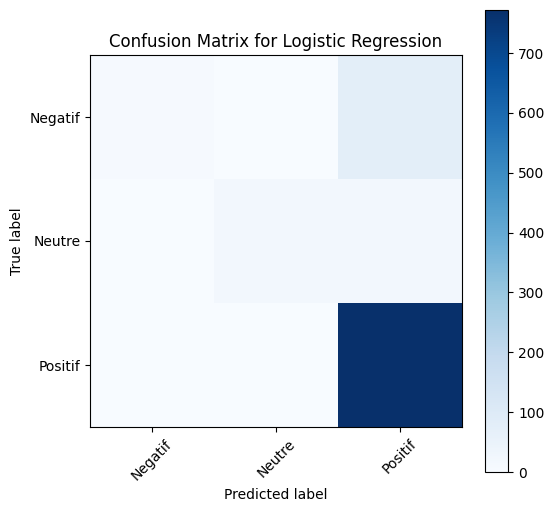

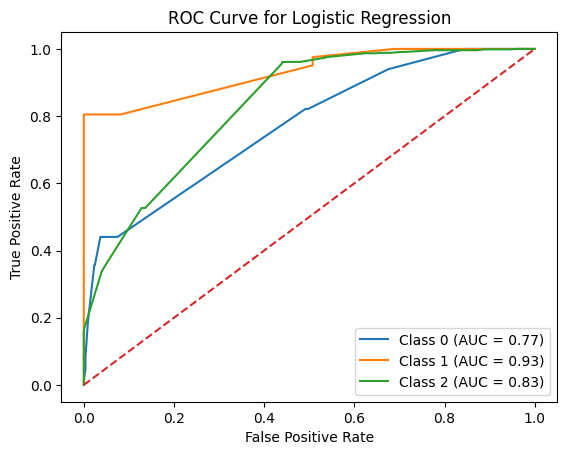

Classification Report for Decision Tree:
              precision    recall  f1-score   support

     Negatif       0.56      0.44      0.49        84
      Neutre       1.00      0.71      0.83        41
     Positif       0.93      0.96      0.94       775

    accuracy                           0.90       900
   macro avg       0.83      0.70      0.76       900
weighted avg       0.90      0.90      0.90       900



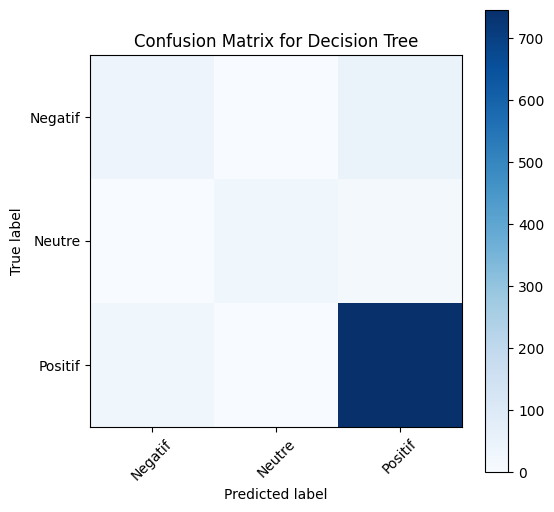

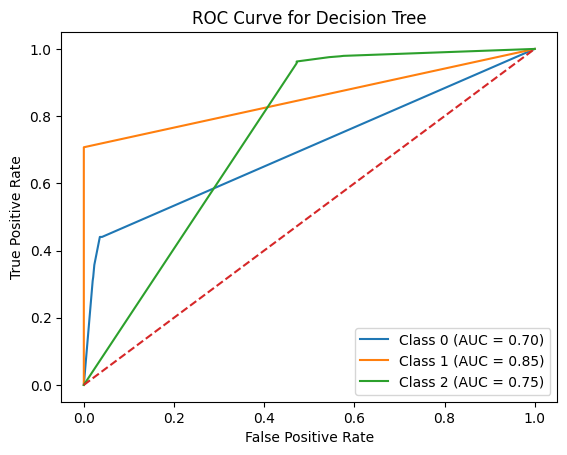

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Negatif       0.61      0.36      0.45        84
      Neutre       1.00      0.68      0.81        41
     Positif       0.92      0.98      0.95       775

    accuracy                           0.90       900
   macro avg       0.84      0.67      0.74       900
weighted avg       0.89      0.90      0.89       900



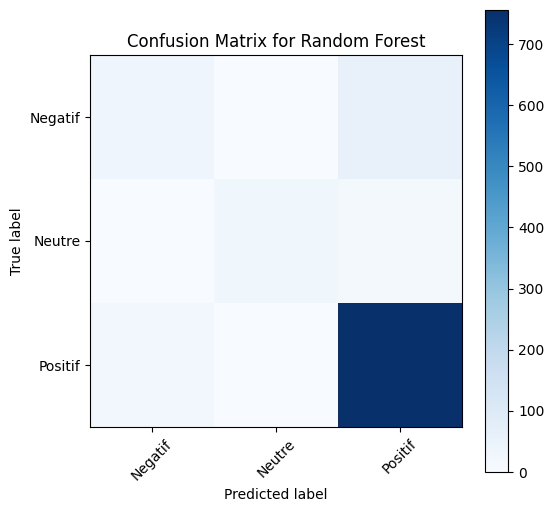

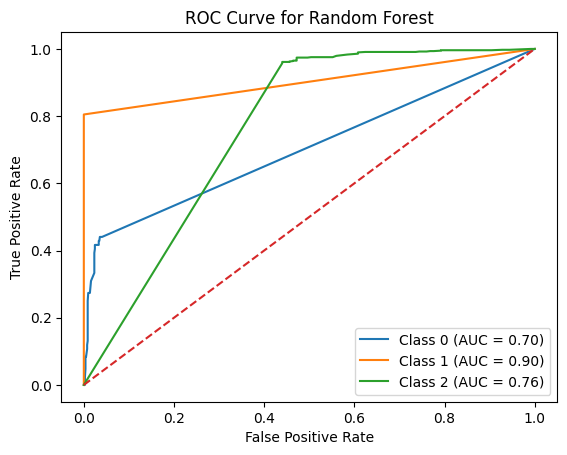

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

     Negatif       0.68      0.18      0.28        84
      Neutre       1.00      0.68      0.81        41
     Positif       0.90      0.99      0.95       775

    accuracy                           0.90       900
   macro avg       0.86      0.62      0.68       900
weighted avg       0.89      0.90      0.88       900



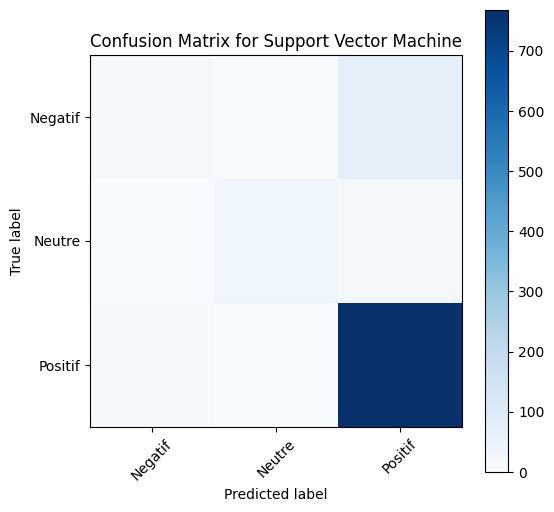

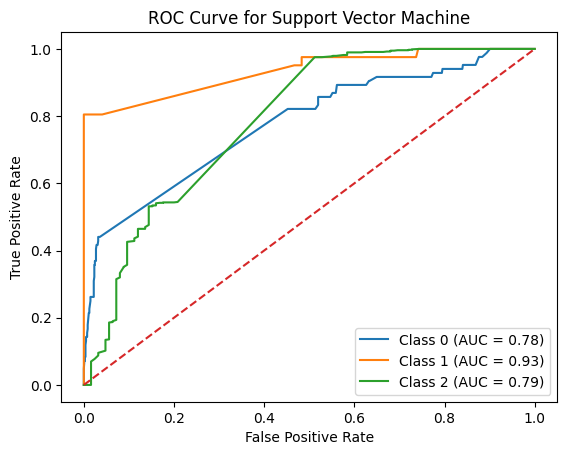

In [36]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load the dataset
file_path = r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\lexicon_expanded.xlsx'  # Path to the expanded lexicon
df = pd.read_excel(file_path)

# Ensure columns are named correctly and include English and South African languages
df.columns = ['ciluba', 'french', 'score', 'sentiment', 'nature', 'english', 'afrikaans', 'zulu', 'xhosa']

# Step 1: Translation functions
def translate_text_using_lexicon(text, lexicon):
    words = text.lower().split()
    translated_words = [lexicon.get(word, word) for word in words]
    return ' '.join(translated_words)

# Create translation lexicon from the dataset
translation_lexique = dict(zip(df['french'].str.lower(), df['ciluba']))

# Step 2: Sentiment Analysis Function
lexique = dict(zip(df['ciluba'].str.lower(), df['score']))

def analyse_sentiment(text):
    words = text.lower().split()
    word_scores = {word: lexique.get(word, 0) for word in words}
    score = sum(word_scores.values())
    if score > 0.05:
        sentiment = "Positive"
    elif score < -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return score, sentiment, word_scores

# Step 3: Machine Learning Pipeline
def preprocess_and_train_ml_models(df):
    # Prepare the dataset for machine learning
    df = df.dropna(subset=['french', 'score', 'sentiment'])  # Drop rows with missing values
    X = df['french']  # Features (text)
    y = df['sentiment']  # Target (sentiment labels)

    # Binarize the output for multi-class ROC
    y_bin = label_binarize(y, classes=['Negatif', 'Neutre', 'Positif'])
    n_classes = y_bin.shape[1]

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Feature extraction using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Initialize machine learning models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Support Vector Machine": SVC(probability=True)
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        y_proba = model.predict_proba(X_test_tfidf) if hasattr(model, "predict_proba") else None

        # Print classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred, target_names=['Negatif', 'Neutre', 'Positif']))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.colorbar()
        tick_marks = range(n_classes)
        plt.xticks(tick_marks, ['Negatif', 'Neutre', 'Positif'], rotation=45)
        plt.yticks(tick_marks, ['Negatif', 'Neutre', 'Positif'])
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # ROC Curve
        if y_proba is not None:
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=['Negatif', 'Neutre', 'Positif'])[:, i], y_proba[:, i])
                roc_auc[i] = roc_auc_score(label_binarize(y_test, classes=['Negatif', 'Neutre', 'Positif'])[:, i], y_proba[:, i])

            # Plot ROC curve for each class
            plt.figure()
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.title(f'ROC Curve for {model_name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

# Run the updated machine learning pipeline
preprocess_and_train_ml_models(df)


C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_26880\1829017994.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ciluba', palette='viridis', order=df['ciluba'].value_counts().index)
C:\Users\AlexGreyling\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


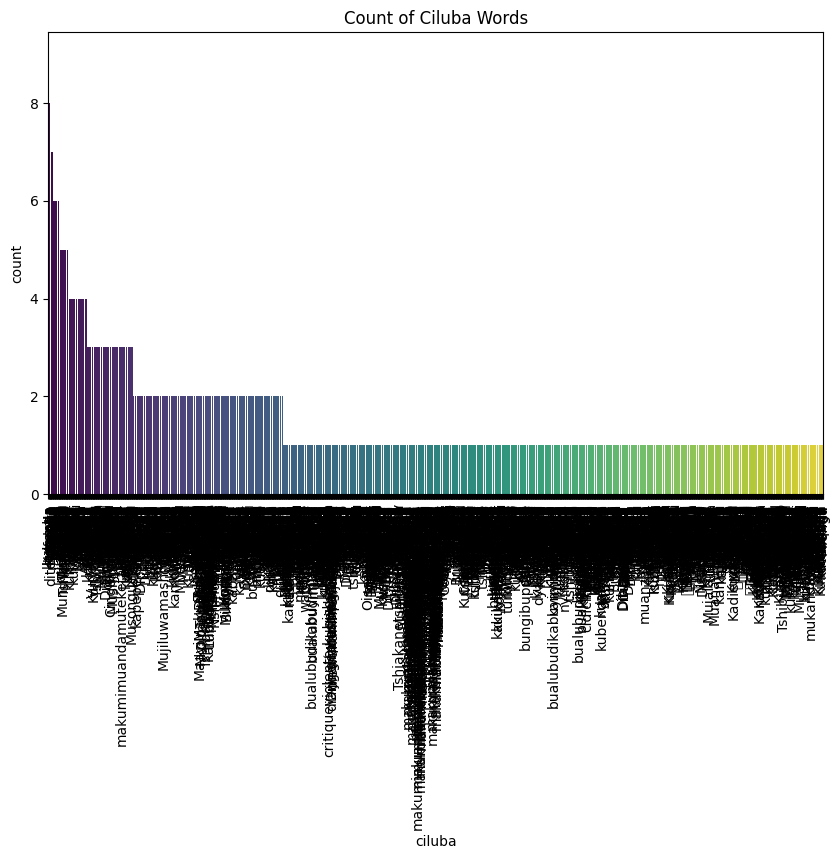

C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_26880\1829017994.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='french', palette='viridis', order=df['french'].value_counts().index)


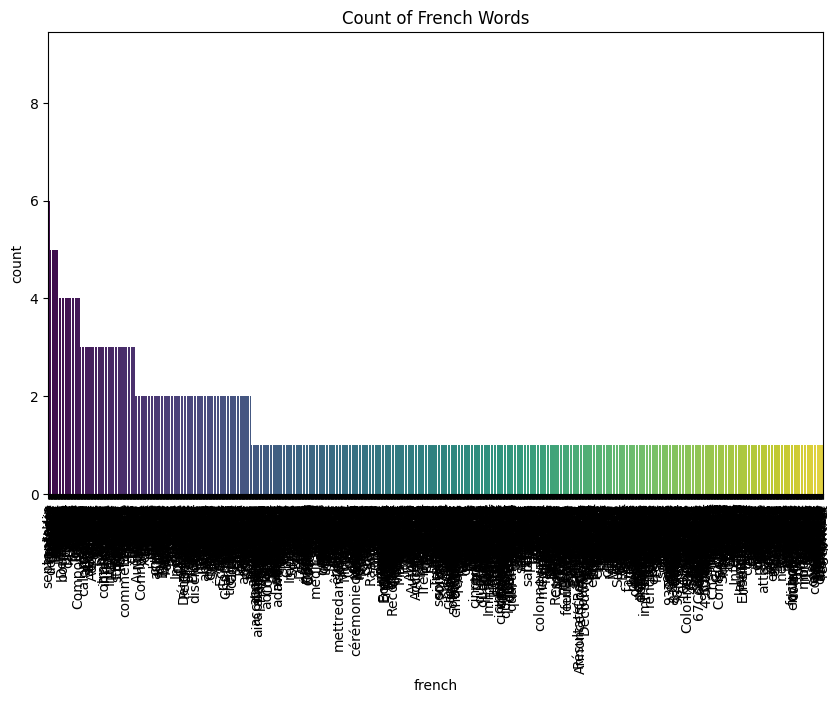

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot word count distribution for Ciluba
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ciluba', palette='viridis', order=df['ciluba'].value_counts().index)
plt.title('Count of Ciluba Words')
plt.xticks(rotation=90)
plt.show()

# Plot word count distribution for French
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='french', palette='viridis', order=df['french'].value_counts().index)
plt.title('Count of French Words')
plt.xticks(rotation=90)
plt.show()


C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_26880\486520100.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Blues')


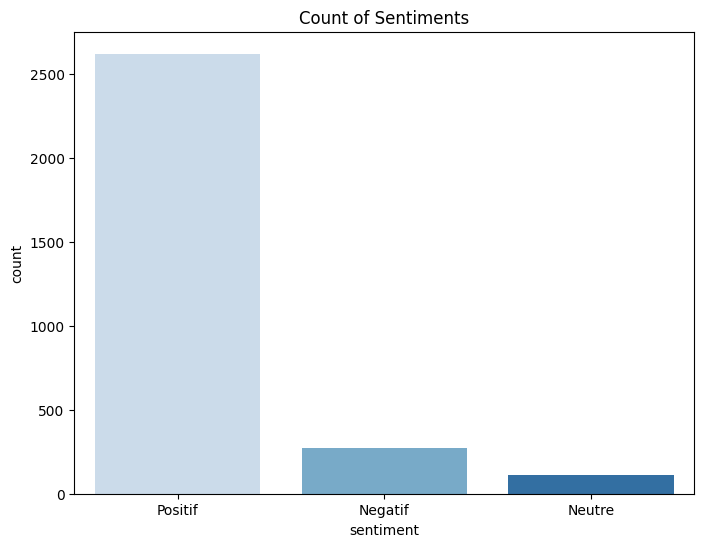

In [38]:
# Plot sentiment distribution (positive, negative, neutral)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette='Blues')
plt.title('Count of Sentiments')
plt.show()


C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_26880\3180965356.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='score', bins=20, kde=True, palette='Greens')


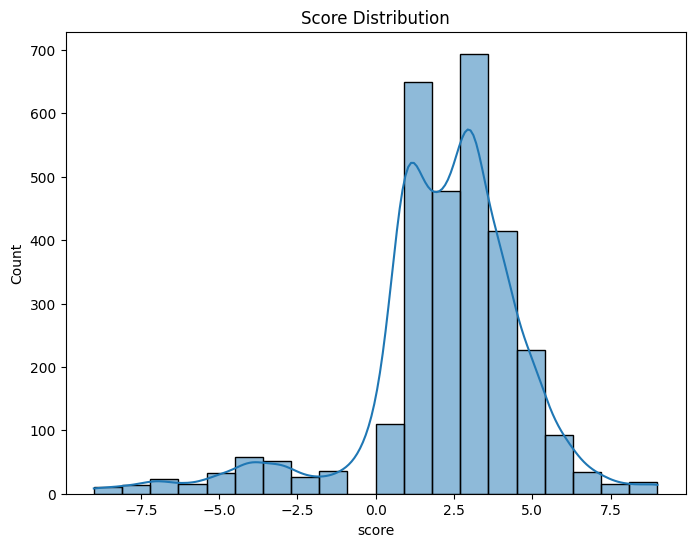

In [39]:
# Plot score distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='score', bins=20, kde=True, palette='Greens')
plt.title('Score Distribution')
plt.show()


C:\Users\AlexGreyling\AppData\Local\Temp\ipykernel_26880\1990053449.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='nature', palette='Purples')


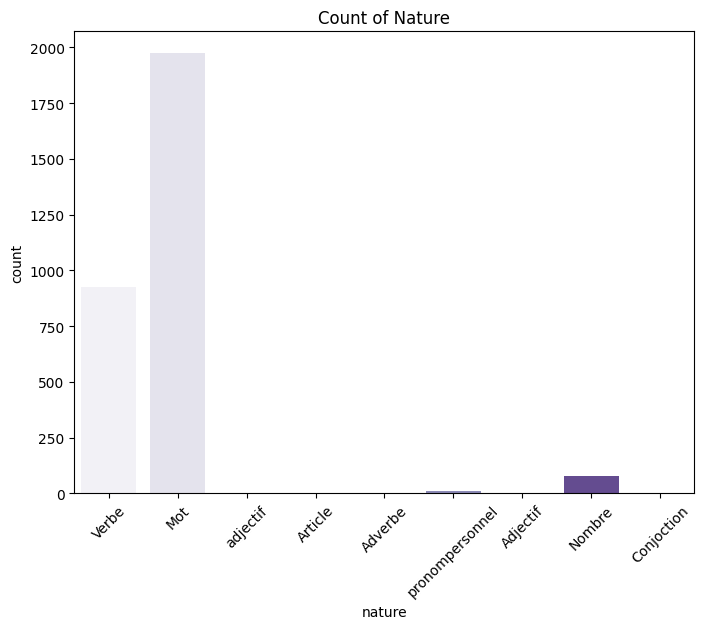

In [40]:
# Plot distribution of "nature" (categorical variable)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='nature', palette='Purples')
plt.title('Count of Nature')
plt.xticks(rotation=45)
plt.show()


In [41]:
# Load your dataset
file_path = r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\coherent_english_sentences_dataset_v2.xlsx'
df_sentences = pd.read_excel(file_path)

# Print column names to verify them
print("Columns in the dataset:", df.columns)

# Ensure columns are named correctly
# Uncomment and adjust the column names as needed based on the output
# df.columns = ['ciluba', 'french', 'score', 'sentiment', 'nature']

# Display first few rows to inspect data structure
print(df_sentences.head())

Columns in the dataset: Index(['ciluba', 'french', 'score', 'sentiment', 'nature', 'english',
       'afrikaans', 'zulu', 'xhosa'],
      dtype='object')
                                   English Sentences
0   On the top of the hill, the stars began to fade.
1  In the middle of the forest, the moonlight ill...
2  She was reading her favorite book when a myste...
3  As the music played softly, an unexpected visi...
4  He opened the door to find they exchanged stor...


In [ ]:
import pandas as pd
import time
from deep_translator import MyMemoryTranslator
from textblob import TextBlob

# Function to translate text using MyMemoryTranslator with retries
def translate_text(text, source_language, target_language, retries=3):
    try:
        translator = MyMemoryTranslator(source=source_language, target=target_language)
        translation = translator.translate(text)
        return translation
    except Exception as e:
        if retries > 0:
            print(f"Retrying translation for {text}... ({3 - retries} retries left)")
            time.sleep(2)  # Wait for 2 seconds before retrying
            return translate_text(text, source_language, target_language, retries - 1)
        return f"Error: {e}"

# Function to perform sentiment analysis and compute sentiment score
def analyze_sentiment(text):
    blob = TextBlob(text)
    
    # Get polarity score (-1 to 1)
    polarity = blob.sentiment.polarity
    
    # Convert polarity to the desired -9 to +9 scale
    sentiment_score = int(polarity * 9)
    
    # Label sentiment based on the score
    if sentiment_score > 0:
        sentiment_label = 'Positive'
    elif sentiment_score < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return sentiment_score, sentiment_label

# Function to translate a selected number of sentences into the chosen language and perform sentiment analysis
def translate_sentences(df, num_sentences, target_language):
    translated_data = []
    
    for idx, row in df.head(num_sentences).iterrows():
        english_sentence = row['English Sentences']
        translated_sentence = translate_text(english_sentence, source_language='en-GB', target_language=target_language)
        
        # Perform sentiment analysis on both the original and translated sentences
        original_sentiment_score, original_sentiment_label = analyze_sentiment(english_sentence)
        translated_sentiment_score, translated_sentiment_label = analyze_sentiment(translated_sentence)
        
        # Append data to the list
        translated_data.append({
            'Original English': english_sentence,
            'Original Sentiment': f"{original_sentiment_label} (Score: {original_sentiment_score})",
            'Translated': translated_sentence,
            'Translated Sentiment': f"{translated_sentiment_label} (Score: {translated_sentiment_score})"
        })
    
    # Create a DataFrame from the translated data
    translated_df = pd.DataFrame(translated_data)
    return translated_df

# Main function to interactively select number of sentences and language
def interactive_translation(df):
    # Prompt the user to choose the number of sentences (up to a maximum of 10)
    while True:
        try:
            num_sentences = int(input("How many sentences would you like to translate? (Max 10): "))
            if 1 <= num_sentences <= 10:
                break
            else:
                print("Please enter a number between 1 and 10.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    # Prompt the user to choose a target language
    languages = {
        '1': ('af-ZA', 'Afrikaans'),
        '2': ('zu-ZA', 'Zulu'),
        '3': ('xh-ZA', 'Xhosa')
    }
    
    print("\nSelect the language you want to translate to:")
    print("1. Afrikaans")
    print("2. Zulu")
    print("3. Xhosa")
    
    while True:
        language_choice = input("Enter the number of the language (1, 2, or 3): ")
        if language_choice in languages:
            target_language_code, target_language_name = languages[language_choice]
            break
        else:
            print("Invalid choice. Please select 1, 2, or 3.")

    # Translate the selected number of sentences and perform sentiment analysis
    translated_df = translate_sentences(df, num_sentences, target_language_code)

    # Display the translated sentences and their sentiment scores
    print(f"\nTranslated {num_sentences} sentences into {target_language_name}:")
    print(translated_df)

# Load your dataset
file_path = r'C:\Users\AlexGreyling\OneDrive - Agile Bridge\Honours\Semester 2\INF 791\Assignment 3\coherent_english_sentences_dataset_v2.xlsx'
df_sentences = pd.read_excel(file_path)

# Call the interactive translation function
interactive_translation(df_sentences)



Select the language you want to translate to:
1. Afrikaans
2. Zulu
3. Xhosa
Retrying translation for On the top of the hill, the stars began to fade.... (0 retries left)
Retrying translation for On the top of the hill, the stars began to fade.... (1 retries left)
Retrying translation for On the top of the hill, the stars began to fade.... (2 retries left)
Retrying translation for In the middle of the forest, the moonlight illuminated the path.... (0 retries left)


In [43]:
import requests
from deep_translator import MyMemoryTranslator
from textblob import TextBlob

# Function to translate text using MyMemoryTranslator with retries and bypass SSL verification
def translate_text(text, source_language, target_language, retries=3):
    try:
        translator = MyMemoryTranslator(source=source_language, target=target_language)
        
        # Bypass SSL verification by overriding requests behavior
        original_get = requests.get
        def new_get(*args, **kwargs):
            kwargs['verify'] = False  # Disable SSL verification
            return original_get(*args, **kwargs)
        requests.get = new_get

        # Perform the translation
        translation = translator.translate(text)
        
        # Restore the original get method
        requests.get = original_get
        return translation
    except Exception as e:
        if retries > 0:
            print(f"Retrying translation for {text}... ({3 - retries} retries left)")
            return translate_text(text, source_language, target_language, retries - 1)
        return f"Error: {e}"

# Function to perform sentiment analysis and compute sentiment score
def analyze_sentiment(text):
    blob = TextBlob(text)
    
    # Get polarity score (-1 to 1)
    polarity = blob.sentiment.polarity
    
    # Convert polarity to the desired -9 to +9 scale
    sentiment_score = int(polarity * 9)
    
    # Label sentiment based on the score
    if sentiment_score > 0:
        sentiment_label = 'Positive'
    elif sentiment_score < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return sentiment_score, sentiment_label

# Function to prompt user for language selection and translate input sentence, with sentiment analysis
def interactive_translation():
    # Define supported languages
    languages = {
        '1': ('af-ZA', 'Afrikaans'),
        '2': ('zu-ZA', 'Zulu'),
        '3': ('xh-ZA', 'Xhosa')
    }

    # Prompt user for language choice
    print("Select the language you want to translate to:")
    print("1. Afrikaans")
    print("2. Zulu")
    print("3. Xhosa")
    choice = input("Enter the number of the language (1, 2, or 3): ")

    # Ensure valid choice
    if choice not in languages:
        print("Invalid choice. Please select 1, 2, or 3.")
        return

    # Get the language code and name
    target_language_code, target_language_name = languages[choice]

    # Prompt user for the sentence in English
    sentence = input(f"Enter the sentence in English to translate into {target_language_name}: ")

    # Translate the sentence
    translated_sentence = translate_text(sentence, source_language='en-GB', target_language=target_language_code)

    # Perform sentiment analysis on both original and translated sentence
    original_sentiment_score, original_sentiment_label = analyze_sentiment(sentence)
    translated_sentiment_score, translated_sentiment_label = analyze_sentiment(translated_sentence)

    # Display the results
    print(f"\nOriginal sentence: {sentence}")
    print(f"Sentiment (Original): {original_sentiment_label} (Score: {original_sentiment_score})")
    print(f"Translated into {target_language_name}: {translated_sentence}")
    print(f"Sentiment (Translated): {translated_sentiment_label} (Score: {translated_sentiment_score})")

# Call the interactive translation function
interactive_translation()


Select the language you want to translate to:
1. Afrikaans
2. Zulu
3. Xhosa


c:\Python312\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.mymemory.translated.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Original sentence: I want to dance
Sentiment (Original): Neutral (Score: 0)
Translated into Afrikaans: Ek wil dans.
Sentiment (Translated): Neutral (Score: 0)
